<a href="https://colab.research.google.com/github/ktgiahieu/BinPickingSimulation/blob/master/Overall_(Impact)_Version_1_(no_training_on_GoodBadPapers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q git+https://github.com/huggingface/peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00


In [3]:
!pip install -q datasets evaluate transformers sentencepiece cpm_kernels iterative-stratification==0.1.7 accelerate jiwer bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install -q py-readability-metrics textstat
!python -m nltk.downloader punkt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.6 MB/s eta 0:00:00
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import argparse
import glob
import os
import pandas as pd
import numpy as np

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftConfig,
    PeftModel
)

import evaluate
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from readability import Readability
import matplotlib.pyplot as plt
import textstat
import os
from scipy import stats


num_workers = 0


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

# Prepare the generate papers

In [6]:
BATCH_SIZE = 1
MAX_LENGTH = 1500 # SHOULD BE HUGE AND COMBINE WITH INT8 TRAINING IN THE FUTURE
model_name_or_path = "microsoft/deberta-v3-large"
fbprize_peft_model_name_or_path = f"ktgiahieu/{model_name_or_path.split('/')[-1]}-ptuning-logimpact-fullpaper"
fbprize_base_model_name_or_path = f"ktgiahieu/base-{model_name_or_path.split('/')[-1]}-peft-p-tuning-fbprize"
task = "mrpc"
peft_type = PeftType.P_TUNING
device = "cuda"
peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128, inference_mode=False)

In [7]:
# from collections import defaultdict

# all_papers = defaultdict(list)
# for folder_path in sorted(glob.glob('/content/gdrive/MyDrive/UPSaclay/LLMs/good_and_bad_papers/*')):
#     if not os.path.isdir(folder_path):
#         continue
#     for file_name in os.listdir(folder_path):
#         if file_name.endswith('.csv'):
#             continue
#         with open(os.path.join(folder_path, file_name), 'r') as f:
#             all_papers[file_name].append(f.read())
# df = pd.DataFrame(all_papers)
## df.to_csv('/content/gdrive/MyDrive/UPSaclay/LLMs/good_and_bad_papers/all_paper.csv', index=False)

In [8]:
df = pd.read_csv('/content/gdrive/MyDrive/UPSaclay/LLMs/good_and_bad_papers/all_paper.csv')

In [13]:
# ===== Tokenizers ===== 

if any(k in model_name_or_path for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# ===== Dataset ======

def prepare_input(text):
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=MAX_LENGTH,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, df, good_col, bad_col):
        self.goods = df[good_col].values
        self.bads = df[bad_col].values

    def __len__(self):
        return len(self.goods)

    def __getitem__(self, item):
        good_texts = self.goods[item]
        bad_texts = self.bads[item]
        good_inputs = prepare_input(good_texts)
        bad_inputs = prepare_input(bad_texts)
        return good_inputs, bad_inputs, good_texts, bad_texts

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

In [15]:
train, valid = train_test_split(df, test_size=0.5, random_state=42)

In [16]:
peft_config = PeftConfig.from_pretrained(fbprize_peft_model_name_or_path)
inference_model = AutoModelForSequenceClassification.from_pretrained(fbprize_base_model_name_or_path, return_dict=True, num_labels=1, problem_type = "regression")

# Load the Lora model
inference_model = PeftModel.from_pretrained(inference_model, fbprize_peft_model_name_or_path)
inference_model.print_trainable_parameters()
inference_model.to(device)
inference_model.eval()
inference_model.print_trainable_parameters()

Some weights of the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize were not used when initializing DebertaV2ForSequenceClassification: ['classifier.modules_to_save.default.bias', 'classifier.original_module.bias', 'classifier.modules_to_save.default.weight', 'classifier.original_module.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ktgiahieu/base-deberta-v3-large-peft-p-tuning-fbprize and are newly initi

trainable params: 22,530 || all params: 435,084,290 || trainable%: 0.005178306943695899
trainable params: 22,530 || all params: 435,084,290 || trainable%: 0.005178306943695899


# Metrics

In [35]:
def get_all_scores(dataloader, good_col, bad_col):
    all_good_scores = []
    all_bad_scores = []
    for step, (goods, bads, good_texts, bad_texts) in enumerate(tqdm(dataloader)):
        goods = collate(goods)
        bads = collate(bads)
        for k, v in goods.items():
            goods[k] = v.to(device)
        for k, v in bads.items():
            bads[k] = v.to(device)

        batch_size = goods['input_ids'].shape[0]

        with torch.no_grad():
            good_outputs = inference_model(**goods)
            bad_outputs = inference_model(**bads)

        good_outputs = good_outputs.logits.cpu().numpy()
        bad_outputs = bad_outputs.logits.cpu().numpy()

        all_good_scores.append(good_outputs)
        all_bad_scores.append(bad_outputs)

    all_good_scores = np.concatenate(all_good_scores, axis=0)
    all_bad_scores = np.concatenate(all_bad_scores, axis=0)

    all_good_scores = np.clip(all_good_scores, 0 , 8)/8
    all_bad_scores = np.clip(all_bad_scores, 0 , 8)/8

    return all_good_scores, all_bad_scores

In [36]:
# def plot_raw_difference(all_good_scores, all_bad_scores):
#     sub_criteria = ['fb_cohesion', 'fb_syntax', 'fb_vocabulary', 'fb_phraseology', 'fb_grammar', 'fb_conventions',
#                 'kincaid', 'dale', 'ari', 'linsear']
#     fig, axes = plt.subplots(2, 5, figsize = (15, 6))
#     for sub_i, sub_criterion in enumerate(sub_criteria):
#         ax = axes[sub_i//5][sub_i%5]
#         good_scores = all_good_scores[:, sub_i] 
#         bad_scores = all_bad_scores[:, sub_i] 

#         # Calculate the differences between paired observations
#         differences = np.array(good_scores) - np.array(bad_scores)

#         # Perform the paired t-test
#         t_statistic, p_value = stats.ttest_rel(good_scores, bad_scores)

#         # Create a boxplot of the differences
#         bp = ax.boxplot(differences, showfliers=False)

#         # Add some random "jitter" to the x-axis
#         x = np.random.normal(1, 0.04, size=len(differences))
#         ax.plot(x, differences, 'r.', alpha=0.5)

#         # Add labels and title
#         ax.set_title(sub_criterion)
#         if sub_i%5==0:
#             ax.set_ylabel('Difference')

#         # Add t-statistic and p-value as text annotation
#         text = f"t-statistic: {t_statistic:.2f}\np-value: {p_value:.2e}"
#         ax.text(0.05, 0.95, text, transform=plt.gca().transAxes, fontsize=10,
#                 verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

#     plt.show()

In [37]:
def plot_combined_score_difference(good_scores, bad_scores):
    plt.figure()

    # Calculate the differences between paired observations
    differences = np.array(good_scores) - np.array(bad_scores)

    # Perform the paired t-test
    t_statistic, p_value = stats.ttest_rel(good_scores, bad_scores)

    # Create a boxplot of the differences
    bp = plt.boxplot(differences, showfliers=False)

    # Add some random "jitter" to the x-axis
    x = np.random.normal(1, 0.04, size=len(differences))
    plt.plot(x, differences, 'r.', alpha=0.5)

    # Add labels and title
    plt.title('Predicted impact')
    plt.xlabel('Log (citation)')
    plt.ylabel('Difference')

    # Add t-statistic and p-value as text annotation
    text = f"t-statistic: {t_statistic:.2f}\np-value: {p_value:.2e}"
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

    plt.show()

In [38]:
def get_raw_and_combined_scores(criterion):
    
    good_col = 'good_1.txt'
    bad_col = [x for x in df.columns if criterion in x][0]

    train_dataset = TrainDataset(train, good_col, bad_col)
    valid_dataset = TrainDataset(valid, good_col, bad_col)

    train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=num_workers, pin_memory=True, drop_last=True)
    eval_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=num_workers, pin_memory=True, drop_last=False)

    train_good_scores, train_bad_scores = get_all_scores(train_dataloader, good_col, bad_col)
    valid_good_scores, valid_bad_scores = get_all_scores(eval_dataloader, good_col, bad_col)

    from sklearn.linear_model import LogisticRegression
    # Logistic Regressor
    X_train = np.concatenate([train_good_scores, train_bad_scores], axis=0)
    y_train = np.concatenate([np.ones(len(train_good_scores)), np.zeros(len(train_bad_scores))], axis=0)

    X_test = np.concatenate([valid_good_scores, valid_bad_scores], axis=0)
    y_test = np.concatenate([np.ones(len(train_good_scores)), np.zeros(len(valid_bad_scores))], axis=0)

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_hat_test = clf.predict_proba(X_test)[:,1]

    combined_good_scores = y_hat_test[:len(train_good_scores)]
    combined_bad_scores = y_hat_test[len(train_good_scores):]

    acc = np.mean((y_hat_test>0.5)==y_test)
    print(f"Accuracy: {acc*100:.2f}")

    return clf, valid_good_scores, valid_bad_scores, combined_good_scores, combined_bad_scores

In [39]:
def plot_temperature(all_good_scores, all_bad_scores):
    import seaborn as sns
    import matplotlib.pyplot as plt
    good_line = sns.lineplot(all_good_scores, label='good', color='red')
    bad_line = sns.lineplot(all_bad_scores, label='bad')

    lines = good_line.get_lines()
    plt.fill_between(lines[0].get_xdata(), lines[1].get_ydata(), lines[0].get_ydata(), color='yellow', alpha=.25, label='difference')
    plt.legend()
    plt.xlabel('Paper pairs')
    plt.ylabel('Predicted score')
    plt.ylim([0,1])
    plt.show()

## Clarity: correct language

  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 83/83 [00:30<00:00,  2.74it/s]

Accuracy: 51.81


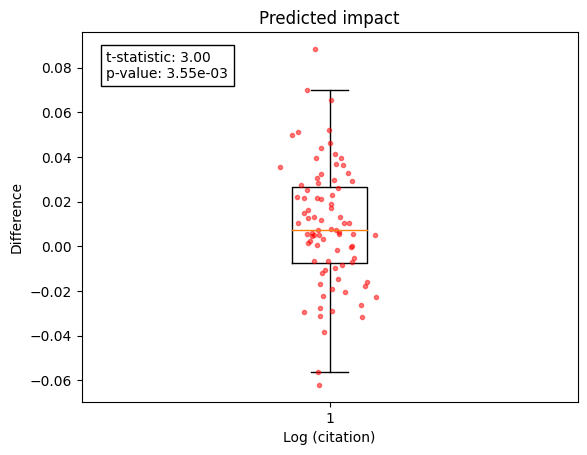

In [40]:
criterion = 'claritycorrectlanguage'
clf, valid_good_scores, valid_bad_scores, combined_good_scores, combined_bad_scores = get_raw_and_combined_scores(criterion)
plot_combined_score_difference(valid_good_scores[:,0], valid_bad_scores[:,0])

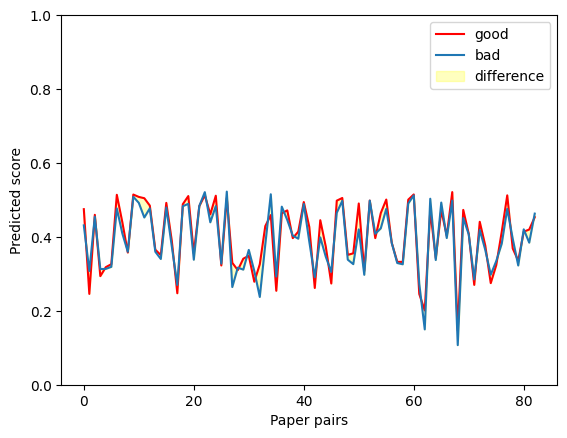

In [41]:
plot_temperature(valid_good_scores[:,0], valid_bad_scores[:,0])

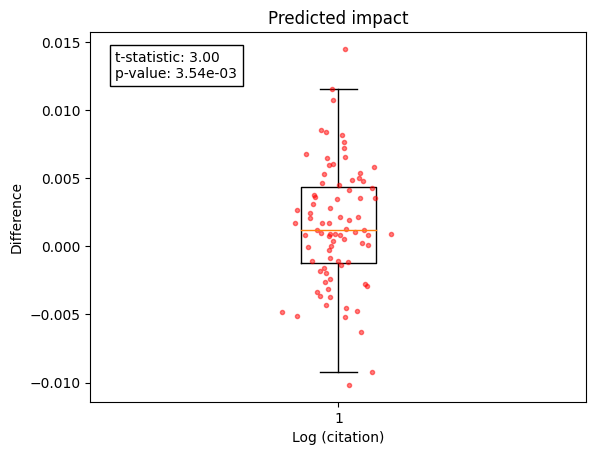

In [42]:
plot_combined_score_difference(combined_good_scores, combined_bad_scores)

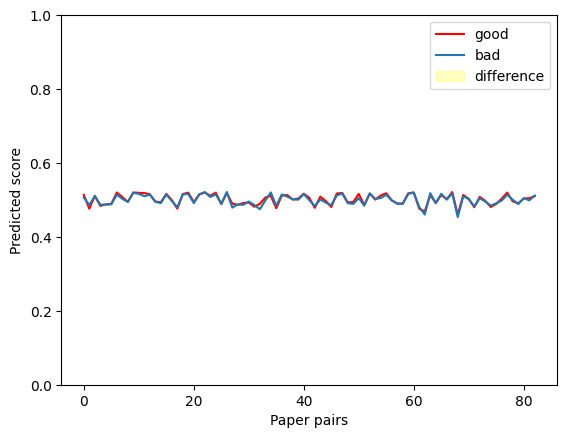

In [43]:
plot_temperature(combined_good_scores, combined_bad_scores)

# Clarity: Explanations

  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 83/83 [00:31<00:00,  2.61it/s]

Accuracy: 50.60


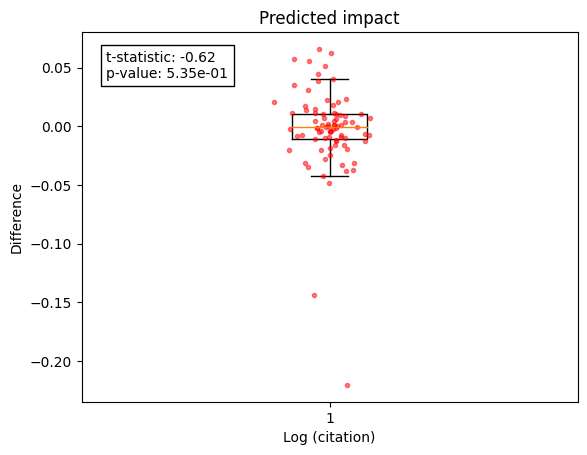

In [44]:
criterion = 'clarityexplanations'
clf, valid_good_scores, valid_bad_scores, combined_good_scores, combined_bad_scores = get_raw_and_combined_scores(criterion)
plot_combined_score_difference(valid_good_scores[:,0], valid_bad_scores[:,0])

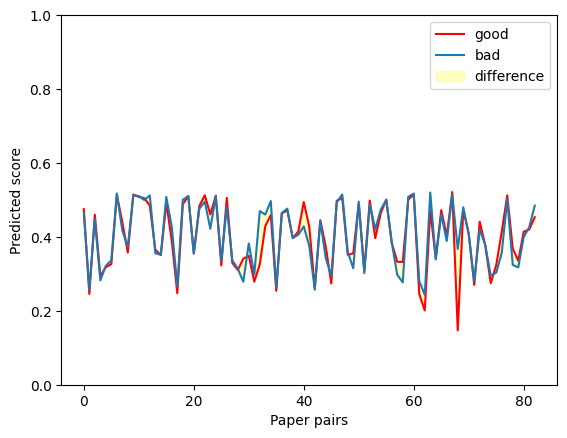

In [45]:
plot_temperature(valid_good_scores[:,0], valid_bad_scores[:,0])

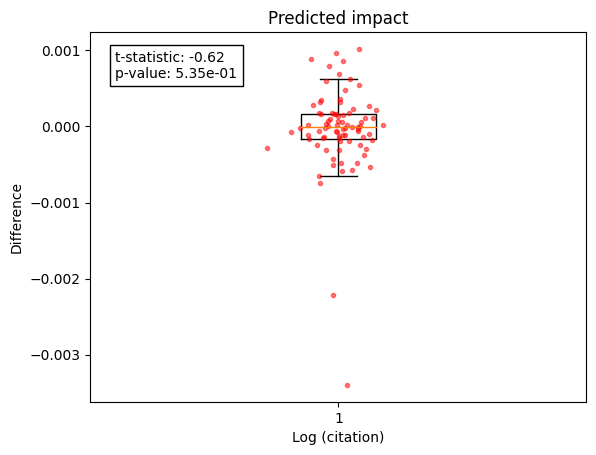

In [46]:
plot_combined_score_difference(combined_good_scores, combined_bad_scores)

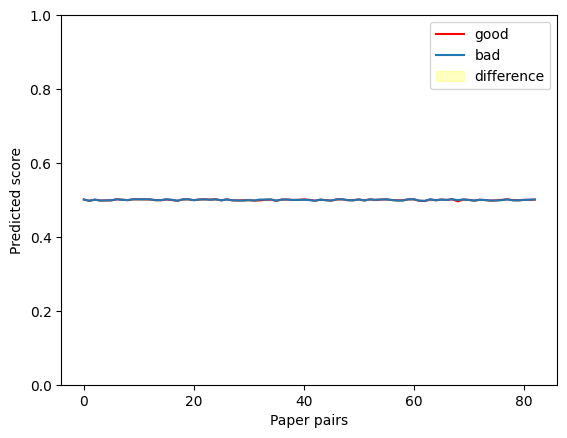

In [47]:
plot_temperature(combined_good_scores, combined_bad_scores)

# Clarity: organization

  0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 83/83 [00:30<00:00,  2.72it/s]

Accuracy: 52.41


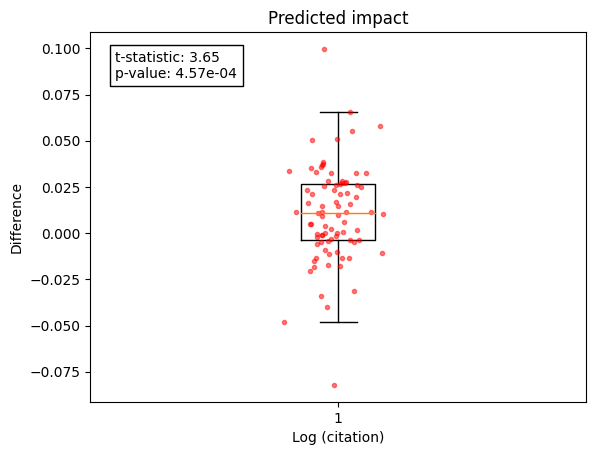

In [48]:
criterion = 'clarityorganization'
clf, valid_good_scores, valid_bad_scores, combined_good_scores, combined_bad_scores = get_raw_and_combined_scores(criterion)
plot_combined_score_difference(valid_good_scores[:,0], valid_bad_scores[:,0])

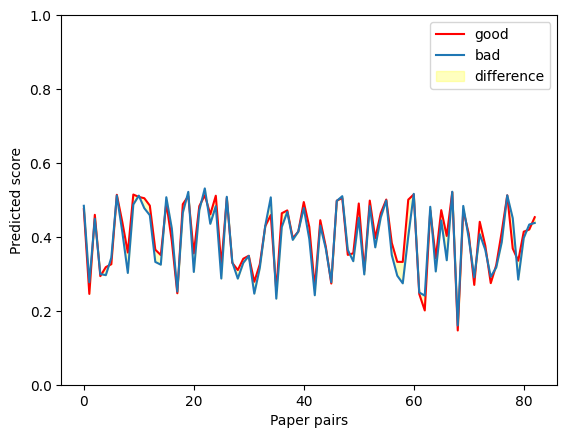

In [49]:
plot_temperature(valid_good_scores[:,0], valid_bad_scores[:,0])

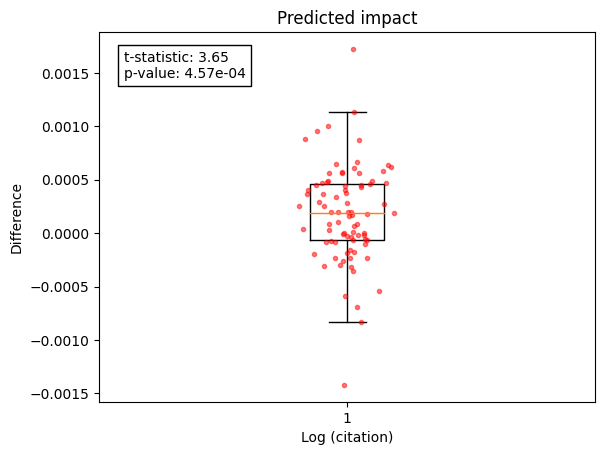

In [50]:
plot_combined_score_difference(combined_good_scores, combined_bad_scores)

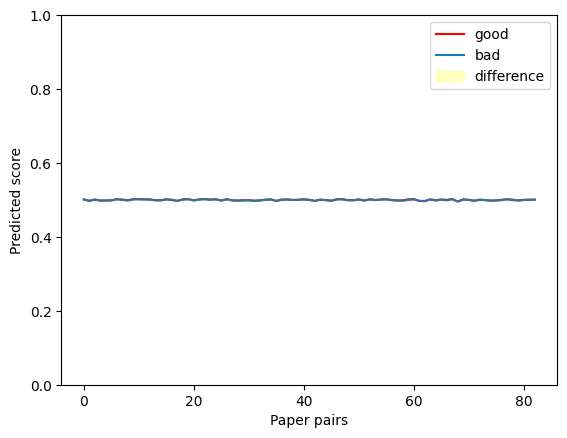

In [51]:
plot_temperature(combined_good_scores, combined_bad_scores)